### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 26th at 11.59pm CT
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [102]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

(1000, 3)


Text(0, 0.5, 'Feature 2')

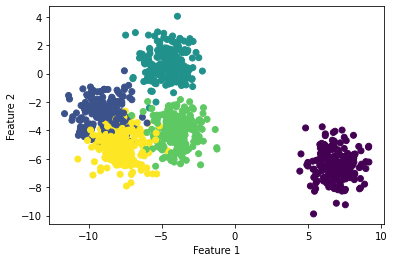

In [135]:
#1) Read in hw6_data_1.npy. The dataset should consist of 1000 samples with 2 features. Note that the last 
#column are the labels, not another feature. Make a 2-D scatter plot of the data colored by their labels.

import numpy as np
import matplotlib.pyplot as plt

#obtaining data from hw6_data_1
data = np.load('../../../../coursework/homeworks/hw_data/hw6_data_1.npy') #reading data
print(np.shape(data))
feats = data[:,[0,1]]
feat1 = data[:,0] #feature 1
feat2 = data[:,1] #feature 2
labels = data[:,2]  #labels go from 0-4

#Obtaining index of each label
idx0 = np.where(labels==0)
idx1 = np.where(labels==1)
idx2 = np.where(labels==2)
idx3 = np.where(labels==3)
idx4 = np.where(labels==4)

#Plotting feature 1 vs feature 2 for each label
plt.scatter(feat1,feat2,c=labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

best bandwidth = 0.4724137931034482


/tmp/ipykernel_30994/3589377161.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


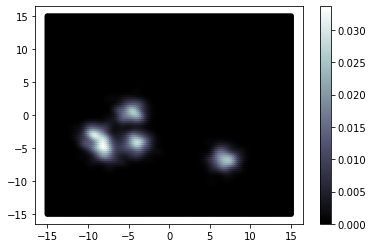

In [136]:
#2) Start with kernel density estimation on the data set. First, perform a grid search 5-fold cross-validation 
#to find the best bandwidth, testing 30 bandwidths between 0.1 and 1.0. What is this best bandwidth? Using this 
#best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#Obtaning best bandwidth
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(feats) #both features
h_opt = grid.best_params_['bandwidth']
print('best bandwidth =', h_opt)

#Kernel Density Estimation
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(feats) 
u = v = np.linspace(-15,15,100) 
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T 
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

#Plotting
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="bone", edgecolor="None") # B)
plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


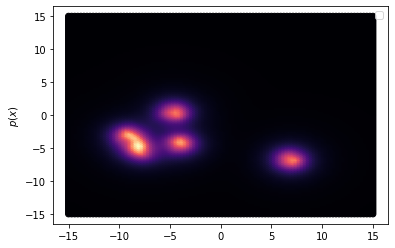

In [137]:
#3) Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. 
#Plot the estimated distribution. What value of 𝑘 neighbors do you need to make the plot look similar to your 
#KDE distribution?

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

#I attempted from low ~10 neighbors until 100 and between 80-100 k values, the plot looks similar to the one 
#above
k = 100 #Number of neighbors

#K neighbor density
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(feats)
dens_nbrs = nbrs.eval(Xgrid) 

#Plotting
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, cmap="magma") # B)
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')

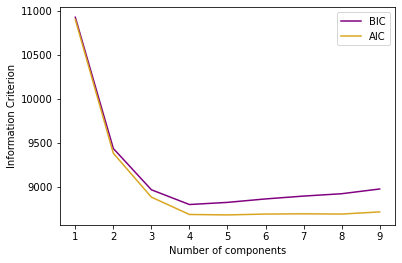

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


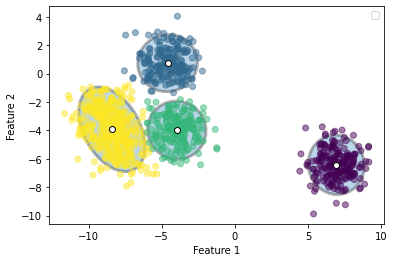

In [134]:
#4) Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between 1 and 10.
#Plot these AIC and BIC values as a function of number of components. What is the optimal number according to 
#the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data 
#set, the GMM component mean locations, and the 2-sigma GMM component ellipses. (Use the code below to help with
#plotting the ellipses.)

from sklearn.mixture import GaussianMixture

BIC = []
AIC = []

#Gaussian Mixture Models with 1-10 components and calculating BIC & AIC
for ii in range(1,10):
    gmm = GaussianMixture(ii)
    gmm.fit(feats)
    BIC.append(gmm.bic(feats))
    AIC.append(gmm.aic(feats))
    
#Plotting BIC & AIC as a function of number of components    
plt.plot(np.arange(1,10), BIC,color='purple',label='BIC');
plt.plot(np.arange(1,10), AIC,color='goldenrod',label='AIC');
plt.xlabel('Number of components');
plt.ylabel('Information Criterion');
plt.legend()
plt.show()

#BIC prefers 4 components (According to plot on the top)
gmmBIC = GaussianMixture(4).fit(feats)

#Fitting data set with optimal number of components, mean, and 2 sigma component ellipses
means = gmmBIC.means_
cov = gmmBIC.covariances_

for i in range(4):
    draw_ellipse(means[i], cov[i], sigmas=[2],alpha=0.3,edgecolor='black',lw=3.0)

#Plotting
plt.scatter(feat1,feat2,c=gmmBIC.predict(feats),alpha=0.5)
plt.scatter(means[:,0],means[:,1],c='w',edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

Text(0.5, 1.0, 'Original Data')

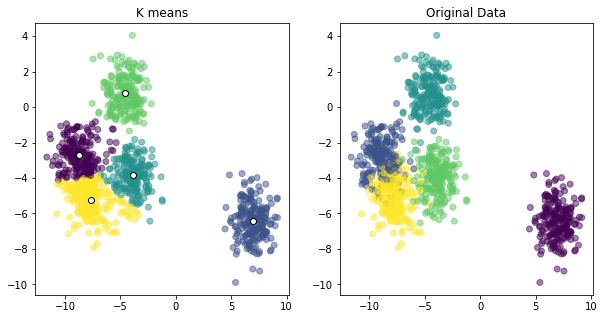

In [140]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(feats))
loc = clf.cluster_centers_
invloc = scaler.inverse_transform(loc)
pred_label = clf.predict(scaler.fit_transform(feats))

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(feat1,feat2,c=pred_label,alpha=0.5)
axes[0].scatter(invloc[:,0],invloc[:,1],c='w',edgecolors='k')
axes[0].set_title('K means')
#plt.show()
axes[1].scatter(feat1,feat2,c=labels,alpha=0.5)
axes[1].set_title('Original Data')
#plt.show()

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [142]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

In [143]:
#2) Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to 2 features. 
#What is the explained variance of the data encapsulated in these eigen-features?

from sklearn.decomposition import PCA

pca = PCA(n_components=2,svd_solver='randomized') # n_components can be optionally set
pca.fit(X) 
evals = pca.explained_variance_ratio_
print('explained fractional variance =', evals) 

explained fractional variance = [0.53320897 0.25010565]


In [123]:
#3) Access the type key of the data structure and make an array of labels out of these. Do some research in 
#astroML documentation to find out what these integer types correspond to, and state that here.

labels2 = data['type']
print(labels2)
print('Resolved and Unresolved sources: the object is a star. If type == 3 (galaxy), if type == 6 (star).')

[3 6 3 ... 3 6 3]
Resolved and Unresolved sources: the object is a star. If type == 3 (galaxy), if type == 6 (star).


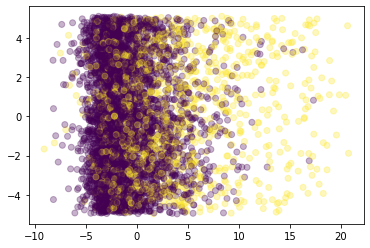

In [127]:
#4) Choose 5000 random integers between 0 and the number of samples in the data matrix. Record these integers 
#because you'll use them later. Make a scatter plot of the PCA-reduced data for these 5000 random samples, 
#colored by their corresponding type.

rand_idxs = np.random.randint(X.shape[0],size=5000) #random indexes
xnu = X[rand_idxs] #x with new indexes
xnu_red = pca.transform(xnu) #x new reduced
plt.scatter(xnu_red[:,0],xnu_red[:,1],alpha=0.3,c=labels2[rand_idxs])

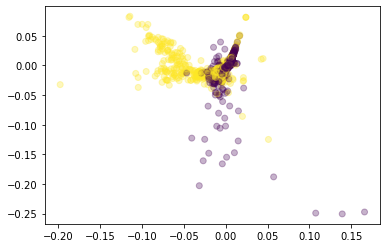

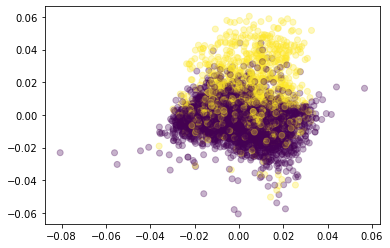

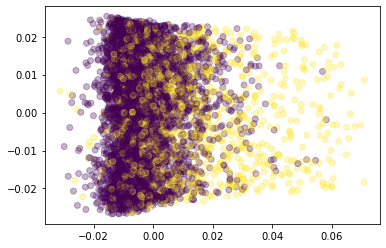

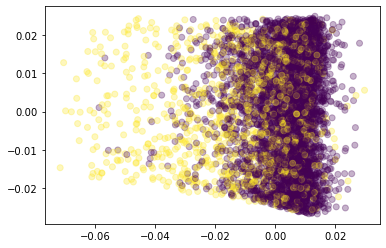

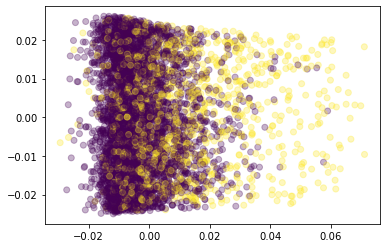

In [129]:
#5) Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only
#on the 5000 random samples identified in the previous part. 

#Try LocallyLinearEmbedding, setting the number of components to be 2.
#As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type. For LLE 
#experiment with the number of nearest neighbors between 5 and 100 to see what visually gives the best separation
#in type populations.

from sklearn.manifold import LocallyLinearEmbedding

k = [5,20,50,80,100] # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

for i in range(len(k)):
    lle = LocallyLinearEmbedding(n_neighbors=k[i], n_components=n)
    lle.fit(xnu)
    proj = lle.transform(xnu) 
    plt.scatter(proj[:,0],proj[:,1],alpha=0.3,c=labels2[rand_idxs])
    plt.show()

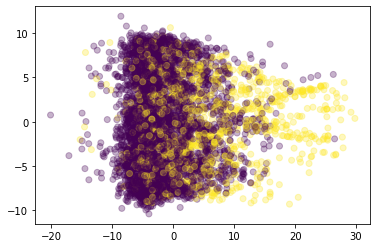

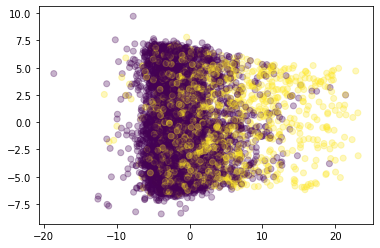

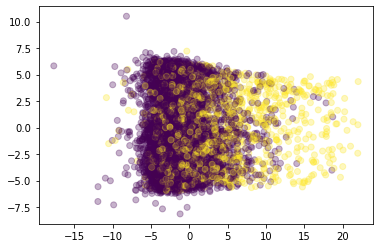

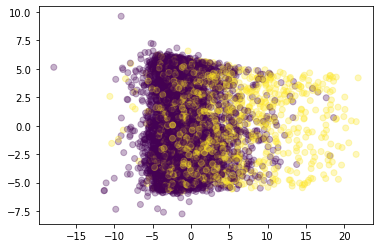

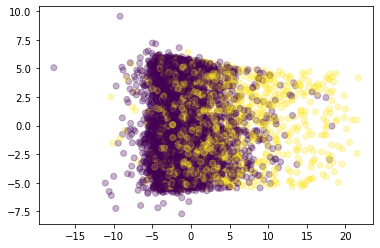

In [130]:
#Try Isomap setting the number of components to be 2 in all cases.
#As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type. For Isomap,
#experiment with the number of nearest neighbors between 5 and 100 to see what visually gives the best separation
#in type populations. 

from sklearn.manifold import Isomap

for i in range(len(k)):
    iso = Isomap(n_neighbors=k[i], n_components=n)
    iso.fit(xnu)
    projiso = iso.transform(xnu) 
    plt.scatter(projiso[:,0],projiso[:,1],alpha=0.3,c=labels2[rand_idxs])
    plt.show()

/home/valeria/githubrepo/ASTR8020/urrutimv/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


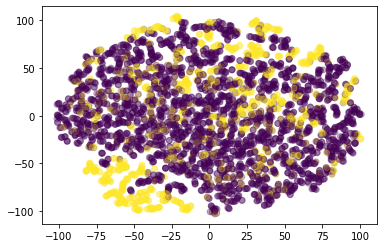

/home/valeria/githubrepo/ASTR8020/urrutimv/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


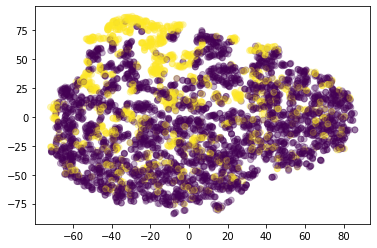

/home/valeria/githubrepo/ASTR8020/urrutimv/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


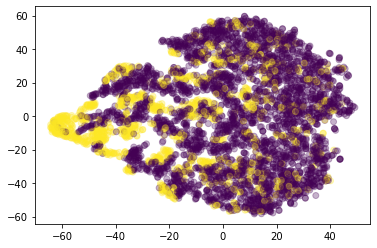

/home/valeria/githubrepo/ASTR8020/urrutimv/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


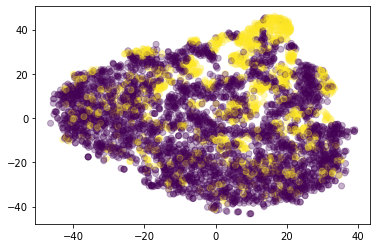

/home/valeria/githubrepo/ASTR8020/urrutimv/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


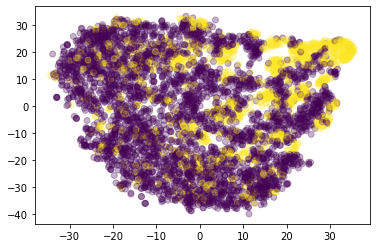

In [132]:
#Try TSNE algorithms, setting the number of components to be 2.
#For TSNE, do the same for the perplexity attribute.

from sklearn.manifold import TSNE

for i in range(len(k)):
    tsne = TSNE(n_components=2,learning_rate=200, perplexity=k[i])
    projtsne = tsne.fit_transform(xnu)
    plt.scatter(projtsne[:,0],projtsne[:,1],alpha=0.3,c=labels2[rand_idxs])
    plt.show()

Which algorithm gives the cleanest way to visually see the two populations of sources? (This will be subjective 
according to the samples you trained on, and even the randomness of the algorithms.)

> In LLE, increasing above k=50 doesn't provide a visually clear way of distinguishing between populations
the plots seem to change much. For k=5, however, I can observe a more distinct clustering between the sources.

> In Isomap does not provide a clear way to distinguish between populations no matter the value of k.

> In TSNE, the perplexity, especially for perplexity=50 there seems to be clustering that allow us to get 
a better idea of the different types of sources

> Besides k=5 plot using LLE, it seems that TSNE has the more consistent and visible clustering of sources